# Predict Home Prices Using Linear Regression


## Deliverables:

1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import feature_selection
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LogisticGAM, LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from scipy import sparse
import models

***

## <font color = Blue>Data Import and Wrangling</font>


In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30


In [4]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [9]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [10]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [11]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

## <font color = Blue> Continue Data Exploration. Also example of feature engineering. Created a column (median price of zipcode the home is in). We can try to see how this feature help in predicting home prices</font>

In [12]:
#add median home value to each row for corresponding zip_code. Also added a log2value for zip_median
zip1 = df.zip_code
list1 = list(zip1)
(df[df.zip_code == list1[3]]).assessed_value.median()

def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

list3 = median_v(df, list1)
list3 = pd.DataFrame(list3, columns=['zip_median'])
df = pd.concat([df, list3], axis=1)
df['log2_zip_median'] = np.log2(df['zip_median'])

In [13]:
#Calculate Haversine distance using latitude and longitude data. Note that I have selected a random reference point
# in LA county for calculating the distance (lat2 = 34.724, lon2 = -117.882)

from math import radians, sin, cos, sqrt, asin
 
 
def haversine(lat1, lon1):
    lat2 = 34.724
    lon2 = -117.882
    R = 6372.8  # Earth radius in kilometers
 
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
 
    a = sin(dLat / 2)**2 + cos(lat1) * cos(lat2) * sin(dLon / 2)**2
    c = 2 * asin(sqrt(a))
 
    return R * c

In [14]:
#create a new column 'Haversine distance'
df['haversine_distance'] = [haversine(x, y) for x, y in zip(df.latitude/1000000, df.longitude/1000000)]

In [15]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,haversine_distance
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431,21.546420
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632,88.899173


In [16]:
# save data in a .csv file
#df.to_csv('zillow_cleaned1.csv')

In [17]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [18]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'haversine_distance', 'assessed_value']]

In [19]:
#df.groupby(['zip_code']).agg(['mean', 'count'])

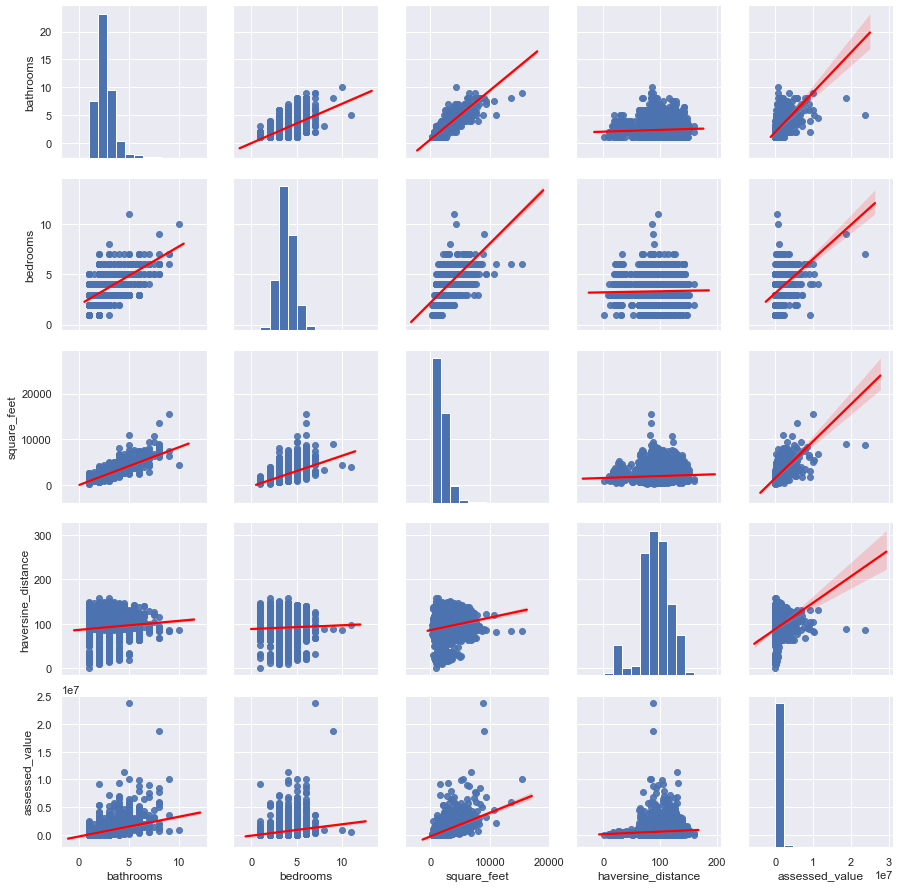

In [20]:
explore.plot_variable_pairs(train_plot)

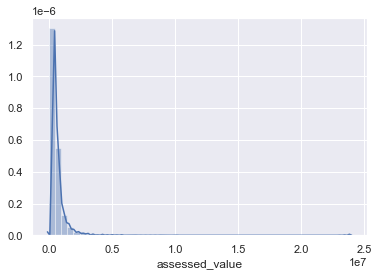

In [21]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [22]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,haversine_distance,assessed_value
bathrooms,1.000000,0.641827,0.854944,0.079816,0.505229
bedrooms,0.641827,1.000000,0.628387,0.030077,0.263875
square_feet,0.854944,0.628387,1.000000,0.108428,0.588502
haversine_distance,0.079816,0.030077,0.108428,1.000000,0.164899
assessed_value,0.505229,0.263875,0.588502,0.164899,1.000000


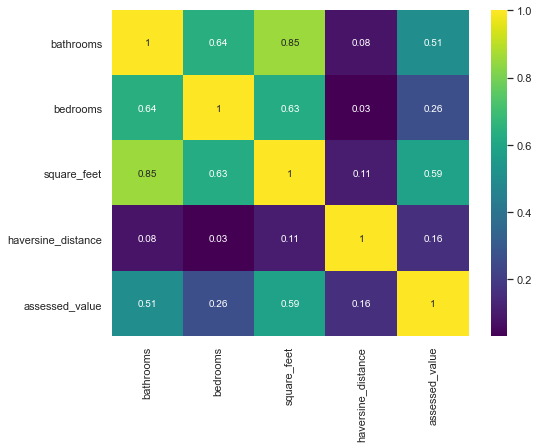

In [23]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

## Use Recursive Feature Engineering to find top 3 features

In [24]:
X = train[['bathrooms', 'bedrooms', 'log2sf', 'log2_zip_median',  'latitude', 'longitude' ,'age']]
y = train[['log2value']]
feature_selection.rfe(X, y, 3)

Index(['bathrooms', 'log2sf', 'log2_zip_median'], dtype='object')

### According to RFE, the top three features are Log2(Square_feet), Log2(zip_median) and number of Bathrooms
***

## Let's look at tax rate distribution in three counties

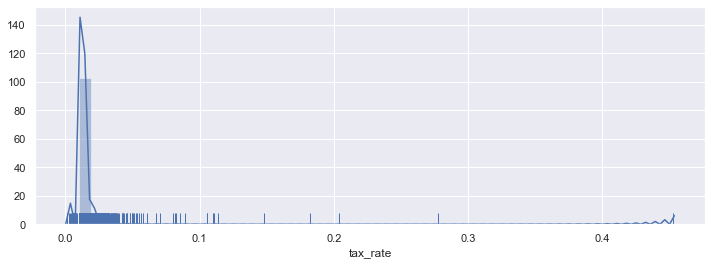

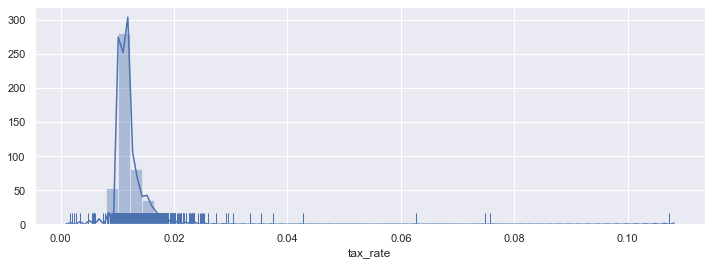

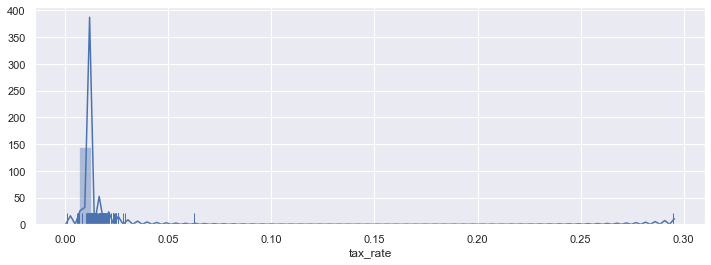

In [25]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

## Lets do some hypothesis testing 

## $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
## $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [26]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['log2sf', 'log2_zip_median', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'log2_zip_median', 'bathrooms']]
y_test = test[['log2value']]

In [27]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.log2value
})
predictions.head(2)

,actual
11938,18.034869
790,16.548476


In [28]:
#predictions['median_bl'] =  train['assessed_value'].median()
#predictions['mean_bl'] =  train['assessed_value'].mean()

In [29]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ log2sf + log2_zip_median + bathrooms',  data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [30]:
predictions['actual1'] =  2**predictions['actual']
predictions['predicted1'] =  2**predictions['ols']

In [31]:
predictions.head(2)

,actual,ols,actual1,predicted1
11938,18.034869,18.144464,268557.0,289752.947292
790,16.548476,18.640519,95849.0,408653.583407


In [32]:
#pd.options.display.float_format = '{:.3f}'.format
#predictions.apply(lambda col: median_absolute_error(predictions.actual1, col))

float('{:.1f}'.format(median_absolute_error(predictions.actual1, predictions.predicted1)))

152095.1

In [33]:
#pd.options.display.float_format = '{:.3f}'.format
#predictions.apply(lambda col: r2_score(predictions.actual1, col))

float('{:.3f}'.format(r2_score(predictions.actual1, predictions.predicted1)))

0.451

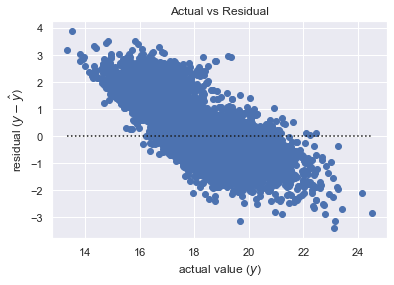

In [34]:
#Lets look at residuals (Log Values)
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)



##  Looks like there is a clear trend. The model seems overestimating lower home prices, but under-estimates significantly at higher price levels. 

In [35]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     2794.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:56:31   Log-Likelihood:                -14992.
No. Observations:               10411   AIC:                         2.999e+04
Df Residuals:                   10407   BIC:                         3.002e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5418      0.340     -1.592      0.111      -1.209       0.125
log2sf              0.5153      0.030     16.973      0.000       0.456       0.575
log2_zip_median     0.6925      0.014     49.873      0.000       0.665       0.720
bathrooms           0.2058      0.019     11.070      0.000       0.169       0.242
==============================================================================
Omnibus:                      893.763   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.121
Skew:                          -0.806   Prob(JB):                    1.62e-248
Kurtosis:                       3.179   Cond. No.                         741.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  Since my p-value is <0.05, I can reject the null hypothesis.
##  This means that there is statistically significant relationship between home prices and  independent variables used above.

***

# Lets apply this model on test data and see how it performs

In [36]:
y_test['y_ols'] = ols_model.predict(X_test)

In [37]:
y_test['actual1'] =  2**y_test['log2value']
y_test['predicted1'] =  2**y_test['y_ols']

In [38]:
#y_test.apply(lambda col: median_absolute_error(y_test.actual1, col))

float('{:.1f}'.format(median_absolute_error(y_test.actual1, y_test.predicted1)))

149995.9

In [39]:
float('{:.3f}'.format(r2_score(y_test.actual1, y_test.predicted1)))

0.528

## The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

***

## Let's do more data exploration, but looking at log(base2)  values of home prices and square feet and median zip values

Text(0.5, 0, 'assessed_value')

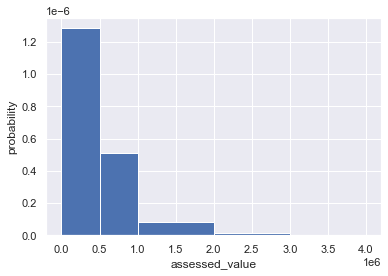

In [40]:
plt.hist(df.assessed_value, density=True, bins =[0, 500000, 1000000, 2000000, 3000000, 4000000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('assessed_value')

## This seems to be right skewed normal distribution

Text(0.5, 0, 'assessed_value')

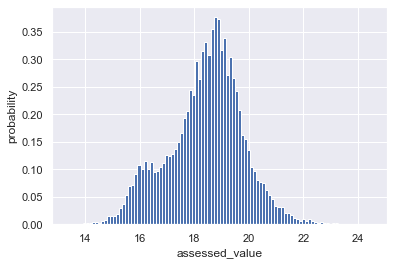

In [41]:
# Transformation to log scale
plt.hist(df.log2value, density=True, bins =100)
plt.ylabel('probability')
plt.xlabel('assessed_value')

## Lets do quantile transformation

In [42]:
y = df[['assessed_value']]
y_trans = quantile_transform(y,
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

Text(0.5, 0, 'assessed_value')

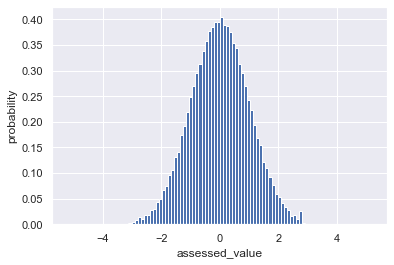

In [43]:
plt.hist(y_trans, density=True, bins =100)
plt.ylabel('probability')
plt.xlabel('assessed_value')

## Wow!! looks much 'normal'!
***

In [44]:
x1 = df[['square_feet']]
y_trans = quantile_transform(x1,
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

Text(0.5, 0, 'transformed square feet')

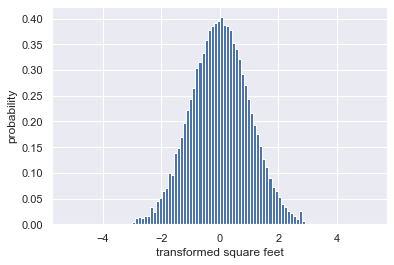

In [45]:
plt.hist(y_trans, density=True, bins =100)
plt.ylabel('probability')
plt.xlabel('transformed square feet')

Text(0.5, 0, 'transformed zip median price')

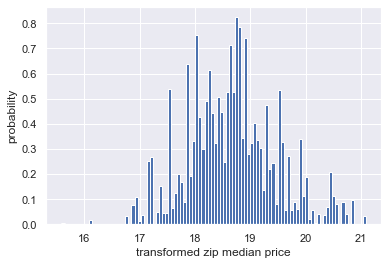

In [46]:
plt.hist(df.log2_zip_median, density=True, bins =100)
plt.ylabel('probability')
plt.xlabel('transformed zip median price')

(8.0, 26.0)

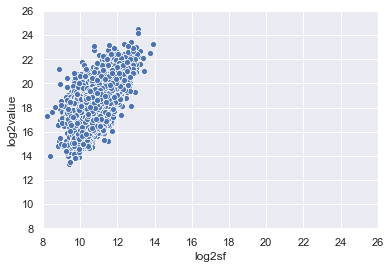

In [47]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2sf', y = 'log2value', data=train, ax = ax)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

(8.0, 26.0)

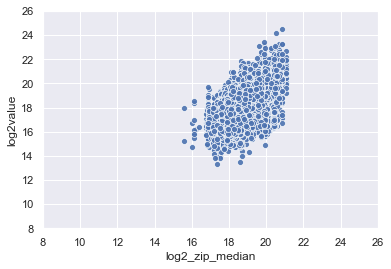

In [48]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train,alpha=0.9)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

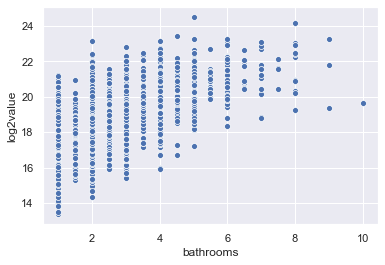

In [49]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

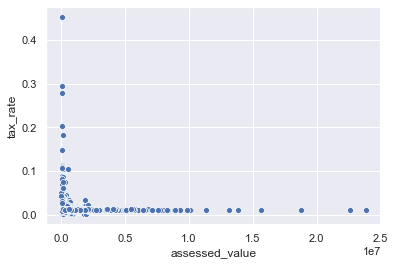

In [50]:
sns.scatterplot(x='assessed_value', y = 'tax_rate', data=df)

## Tax rate seems to be higher for lower valued properties!!

------------------------------------

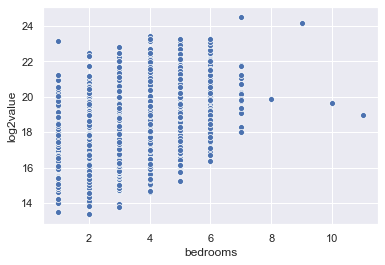

In [51]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# May be we should try to fit a polynomial function to predict price using log2sf

In [52]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [53]:
X_train = train[[ 'log2sf', 'log2_zip_median', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'bathrooms']]
y_test = test[['log2value']]

In [54]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
#poly.get_feature_names()

In [55]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [56]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly

In [57]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.034869,18.092407,268557.0,279484.118630
790,16.548476,18.530351,95849.0,378609.481011


In [58]:
#y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

float('{:.1f}'.format(median_absolute_error(y_train.actual, y_train.poly_predicted)))

152438.3

In [59]:
float('{:.3f}'.format(r2_score(y_train.actual, y_train.poly_predicted)))

0.501

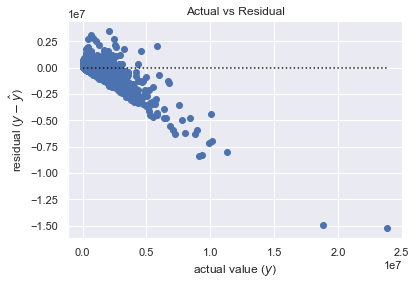

In [60]:
evaluate.plot_residuals(y_train.actual, y_train.poly_predicted, y_train)

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 152,438
# R2 value: 0.501

***

# Generalized Additive Model (GAM)

In [61]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [62]:
X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
y_test = test[['log2value']]

In [63]:
#scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [64]:
X_train= X_train.to_numpy()
y_train = y_train.to_numpy()

In [65]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) +te(3,4))

In [66]:
gam.gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + te(3, 4) + intercept, tol=0.0001, 
   verbose=False)

In [67]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.6472
Link Function:                     IdentityLink Log Likelihood:                                -14888.7661
Number of Samples:                        10411 AIC:                                            29820.8267
                                                AICc:                                           29820.9211
                                                GCV:                                                1.0279
                                                Scale:                                              1.0243
                                                Pseudo R-Squared:                                   0.4571
Feature Function                  Lam

In [68]:
y_pred = gam.predict(X_train)

In [69]:
y_pred

array([17.90045   , 18.51572899, 18.68060713, ..., 17.91915648,
       19.24742209, 17.37548168])

In [70]:
y_pred = pd.DataFrame(y_pred)

In [71]:
y_pred['actual'] =y_train

In [72]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [73]:
y_pred['residual'] = y_pred.actual1-y_pred['predicted1']

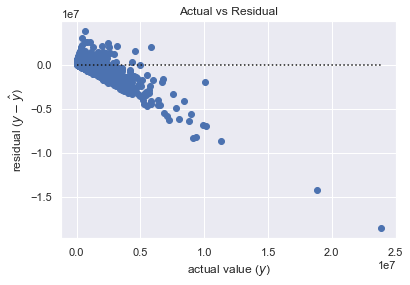

In [74]:
evaluate.plot_residuals(y_pred.actual1, y_pred['predicted1'], y_pred)

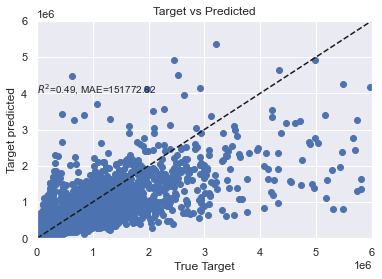

In [75]:
explore.plot_scatter(y_pred['actual1'], y_pred['predicted1'])

In [76]:
float('{:.1f}'.format(median_absolute_error(y_pred.actual1, y_pred.predicted1)))

151772.8

In [77]:
float('{:.3f}'.format(r2_score(y_pred.actual1, y_pred.predicted1)))

0.493

## GAM Summary with test data
## Median Absolute Error: 151,772
## R2 value: 0.493
***

### # Let's plot partial dependence plots for each term in GAM model above



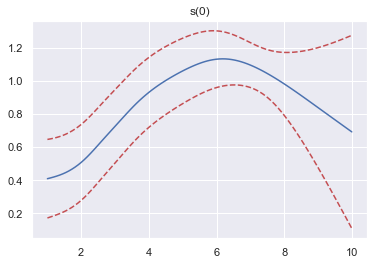

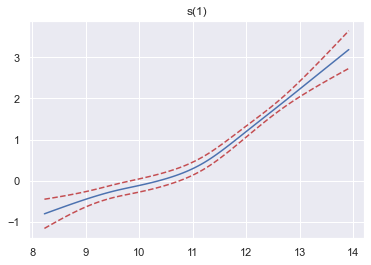

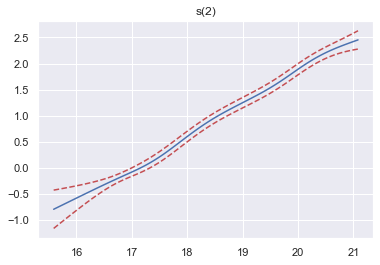

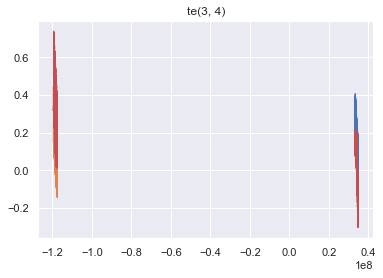

In [78]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

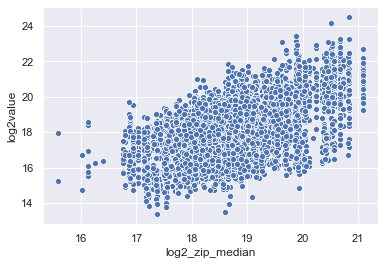

In [79]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

# Lets try a polynomial linear model with X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude']]

In [80]:
X_train = train[['bathrooms', 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median']]
y_test = test[['log2value']]

In [81]:
# X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
# y_train = train[['assessed_value']]
# X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
# y_test = test[['assessed_value']]

In [82]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
#poly.get_feature_names()

In [83]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly.head(2)

,1,bathrooms,log2sf,log2_zip_median,bathrooms^2,bathrooms log2sf,bathrooms log2_zip_median,log2sf^2,log2sf log2_zip_median,log2_zip_median^2,bathrooms^3,bathrooms^2 log2sf,bathrooms^2 log2_zip_median,bathrooms log2sf^2,bathrooms log2sf log2_zip_median,bathrooms log2_zip_median^2,log2sf^3,log2sf^2 log2_zip_median,log2sf log2_zip_median^2,log2_zip_median^3
0,1.0,3.0,11.056638,17.864869,9.0,33.169913,53.594608,122.249238,197.525387,319.153554,27.0,99.509739,160.783823,366.747713,592.576162,957.460661,1351.665531,2183.966646,3528.765219,5701.636511
1,1.0,2.0,10.735556,19.117346,4.0,21.471112,38.234693,115.252163,205.235343,365.472931,8.0,42.942224,76.469385,230.504326,410.470685,730.945861,1237.296054,2203.315518,3923.555123,6986.872591


In [84]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [85]:
y_train.head(2)

,log2value,log_predicted_poly
11938,18.034869,18.092407
790,16.548476,18.530351


In [86]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['log2value'].median()

In [87]:
y_train.head(2)
#y_train.to_csv('poly2_non_spatial.csv')

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.034869,18.092407,268557.0,279484.118629
790,16.548476,18.530351,95849.0,378609.481012


In [88]:
float('{:.1f}'.format(median_absolute_error(y_train.actual, y_train.poly_predicted)))

152438.3

In [89]:
float('{:.3f}'.format(r2_score(y_train.actual, y_train.poly_predicted)))

0.501

## Polynomial Linear  Regression Summary:
## Median Absolute Error: 152,438
## R2 value: 0.501

-----------------------------------------------------

# Lets try Ridge Regression with cross-validation

In [90]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [91]:
X_train = train[[ 'log2sf','bathrooms','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf','bathrooms','latitude', 'longitude']]
y_test = test[['log2value']]

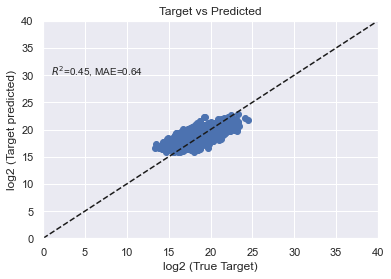

In [92]:
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

explore.plot_scatter_log(y_train, y_pred)

In [93]:
float('{:.1f}'.format(median_absolute_error(2**(y_train), 2**(y_pred))))

152078.3

In [94]:
float('{:.3f}'.format(r2_score(2**(y_train), 2**(y_pred))))

0.451

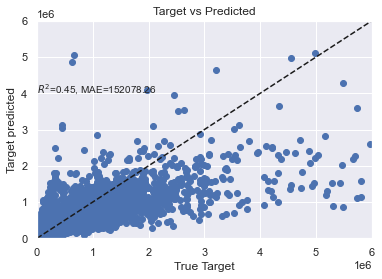

In [95]:
explore.plot_scatter(2**y_train, 2**y_pred)

# Ridge Regression Summary:
# Median Absolute Error: 152,078
# R2 value: 0.451

----------------------------------------

# Lets now try to remove outliers and then do modeling

In [96]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,haversine_distance
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431,21.546420
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632,88.899173


In [97]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [98]:
bath_cutoff = train.bathrooms.mean() + 3*train.bathrooms.std()
bed_cutoff = train.bedrooms.mean() + 3*train.bedrooms.std()
sf_cutoff = train.square_feet.mean() + 3*train.square_feet.std()

In [99]:
bath_cutoff, bed_cutoff , sf_cutoff

(5.37359394534355, 6.097279228580827, 4892.01748519652)

In [100]:
train_out = train[train.bathrooms<bath_cutoff][train.bedrooms<bed_cutoff][train.square_feet<sf_cutoff]

In [101]:
X_train = train_out[['log2_zip_median', 'bathrooms', 'log2sf']]
y_train = train_out[['log2value']]

In [102]:
predictions = pd.DataFrame({
    'actual_log': y_train.log2value
})
predictions.head(2)

,actual_log
11938,18.034869
790,16.548476


In [103]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ log2_zip_median + bathrooms + log2sf', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols_log'] = ols_model.predict(X_train)

In [104]:
predictions['actual'] = 2**predictions.actual_log
predictions['ols_predicted'] = 2**predictions.ols_log

In [105]:
float('{:.1f}'.format(median_absolute_error(2**(y_train), 2**predictions.ols_log)))

149571.8

In [106]:
float('{:.3f}'.format(r2_score(2**(y_train), 2**predictions.ols_log)))

0.411

In [107]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     2794.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:56:42   Log-Likelihood:                -14992.
No. Observations:               10411   AIC:                         2.999e+04
Df Residuals:                   10407   BIC:                         3.002e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5418      0.340     -1.592      0.111      -1.209       0.125
log2_zip_median     0.6925      0.014     49.873      0.000       0.665       0.720
bathrooms           0.2058      0.019     11.070      0.000       0.169       0.242
log2sf              0.5153      0.030     16.973      0.000       0.456       0.575
==============================================================================
Omnibus:                      893.763   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.121
Skew:                          -0.806   Prob(JB):                    1.62e-248
Kurtosis:                       3.179   Cond. No.                         741.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Now we apply the transformation to the test dataset using the cutoff point calculated from the training dataset.

In [108]:
test.bedrooms = np.where(test.bedrooms > bed_cutoff, np.nan, test.bedrooms)
test.bedrooms = test.bedrooms.fillna(bed_cutoff)

In [109]:
test.bathrooms = np.where(test.bathrooms > bath_cutoff, np.nan, test.bathrooms)
test.bathrooms = test.bathrooms.fillna(bath_cutoff)

In [110]:
test.square_feet = np.where(test.square_feet > sf_cutoff, np.nan, test.square_feet)
test.square_feet = test.square_feet.fillna(sf_cutoff)

In [111]:
test_out = test

In [112]:
X_test = test_out[['log2_zip_median', 'bathrooms', 'log2sf']]
y_test = test_out[['log2value']]

In [113]:
predictions2 = pd.DataFrame({
    'actual_log': y_test.log2value
})
predictions2.head(2)

,actual_log
9116,20.367157
2397,19.604834


In [114]:
predictions2['test_ols_log'] = ols_model.predict(X_test)

In [115]:
float('{:.1f}'.format(median_absolute_error(2**(predictions2.actual_log), 2**predictions2.test_ols_log)))

149682.5

In [116]:
float('{:.3f}'.format(r2_score(2**(predictions2.actual_log), 2**predictions2.test_ols_log)))

0.455

## With removal of outliers, the OLS model improved slightly. We can now explore and see if spatial-GAM model improves with outlier removal

## GAM spatial model with outliers removed

In [117]:
X_train = train_out[['zip_median', 'bathrooms', 'square_feet', 'latitude', 'longitude']]
y_train = train_out[['assessed_value']]

In [118]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [119]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(terms = s(0) + s(1) + s(2) + te(3,4))

In [120]:
gam.gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + te(3, 4) + intercept, tol=0.0001, 
   verbose=False)

In [121]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     95.8862
Link Function:                     IdentityLink Log Likelihood:                               -270033.5802
Number of Samples:                        10177 AIC:                                           540260.9329
                                                AICc:                                          540262.8147
                                                GCV:                                     135449352826.5707
                                                Scale:                                   133154163375.3371
                                                Pseudo R-Squared:                                   0.5119
Feature Function                  Lam

In [122]:
y_pred = gam.predict(X_train)
y_pred = pd.DataFrame(y_pred,columns = ['predicted'])

In [123]:
y_pred['actual'] = y_train

In [124]:
y_pred.head(2)

,predicted,actual
0,218015.712461,268557.0
1,378353.081172,95849.0


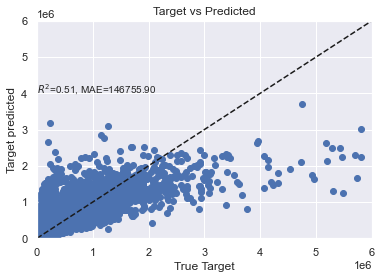

In [125]:
explore.plot_scatter(y_pred.actual, y_pred.predicted)

In [126]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

predicted    146755.904733
actual            0.000000
dtype: float64

In [127]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

predicted    0.511916
actual       1.000000
dtype: float64

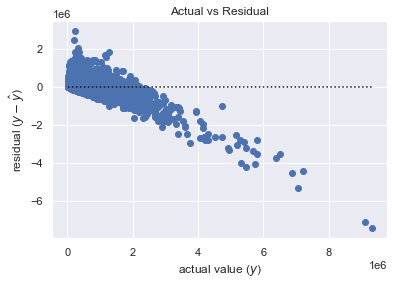

In [128]:
evaluate.plot_residuals(y_pred.actual, y_pred['predicted'], y_pred)

### Lets run the same model on tranformed test data.

In [129]:
X_test = test_out[['zip_median', 'bathrooms', 'square_feet', 'latitude', 'longitude']]
y_test = test_out[['assessed_value']]

In [130]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [131]:
y_pred = gam.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns = ['predicted'])
y_pred['actual'] = y_test

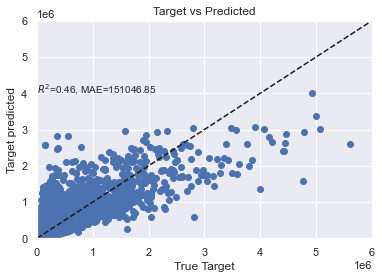

In [132]:
explore.plot_scatter(y_pred.actual, y_pred.predicted)

In [133]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

predicted    151046.853781
actual            0.000000
dtype: float64

In [134]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

predicted    0.463406
actual       1.000000
dtype: float64

### The test model performed decently compared to training model. Test MAE = 151,046 and R2 = 0.463

***

## -----------GAM simulations with ALL data (non-log parameters)-------


In [135]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [136]:
X_train = train[['bathrooms', 'square_feet', 'zip_median', 'latitude', 'longitude']]
y_train = train[['assessed_value']]

In [137]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [138]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(terms = s(0) + s(1) + s(2) + te(3,4))

In [139]:
gam.gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + te(3, 4) + intercept, tol=0.0001, 
   verbose=False)

In [140]:
y_pred = gam.predict(X_train)

In [141]:
y_pred = pd.DataFrame(y_pred, columns = ['predicted'])
y_pred['actual'] = y_train
#y_pred.to_csv('GAM-spatial.csv')

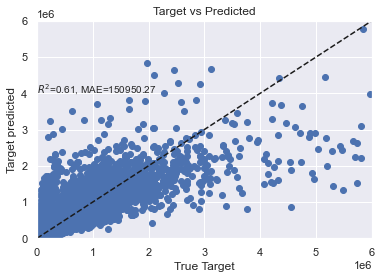

In [142]:
explore.plot_scatter(y_pred.actual, y_pred.predicted)

In [143]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

predicted    150950.269598
actual            0.000000
dtype: float64

In [144]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

predicted    0.605804
actual       1.000000
dtype: float64

### Let's run this model on test data

In [145]:
X_test = test[['bathrooms', 'square_feet', 'zip_median', 'latitude', 'longitude']]
y_test = test[['assessed_value']]

In [146]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [147]:
y_pred = gam.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns = ['predicted'])
y_pred['actual'] = y_test

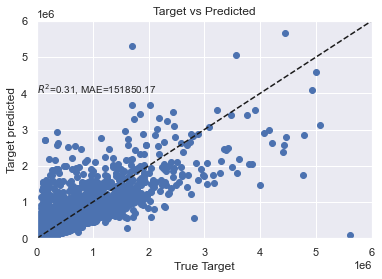

In [148]:
explore.plot_scatter(y_pred.actual, y_pred.predicted)

In [149]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

predicted    151850.165276
actual            0.000000
dtype: float64

In [150]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

predicted    0.310905
actual       1.000000
dtype: float64

## Training MAE = 150,950 , R2 = 0.605
## Test MAE = 151,850,  R2 = 0.31

## The model perfomed well on training, but R2 values dropped for test data. The MAE is almost the same.